# Vanilla GAN

# 1. Imports

In [1]:
# importing other dependencies
import numpy as np
import pandas as pd
# importing PyTorch
import torch
# importing torch.nn Module
import torch.nn as nn
# to load the activation functions
import torch.nn.functional as F
from torch.autograd.variable import Variable
# importing Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, TensorDataset
# create datasets using `ImageFolder`
from torchvision.datasets import ImageFolder
# import compose and other transformations
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Resize, CenterCrop
# plotting
import matplotlib.pyplot as plt
# for keeping track of progress
from tqdm import tqdm
# to compute accuracy
from sklearn.metrics import accuracy_score

# for file paths
import os
# for time
import time
# for copying
import copy

In [2]:
# checks whether MPS is available
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# setting the device to "mps" instead of default "cpu"
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")

# setting the device to "cpu"
# device = torch.device("cpu")

True
True


In [3]:
# check the device
device

device(type='mps')

# 2. Preparing Data

In [18]:
# model hyper-parameters

# input_size of discriminator and output size of generator
input_size = 28*28
# size of the noise vector, input_size for generator
noise_size = 128
# size of hidden layer in 
hidden_size = 256


# other hyper-parameters
batch_size = 512
num_epochs = 250

# no. of epochs of training discriminator per epoch of generator training
k = 1

In [19]:
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# we want the pixel values in each individual channel to have a value between 0 and 1, with a mean of 0.5 and std dev of 0.25.
mean = np.array([0.5,])
std = np.array([0.5,])

transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

# train
# keep download=True, the first time
'''
train_dataset = MNIST(
    root='./data/MNIST/',
    train=True,
    transform=transform,
    download=True
)
'''
train_dataset = MNIST(
    root='./data/MNIST/',
    train=True,
    transform=transform
)
#'''

# test
test_dataset = MNIST(
    root='./data/MNIST/',
    train=False,
    transform=transform
    # don't have to download again
)

# DataLoader
image_dataloaders = {
    'train' : DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    ),
    'test' : DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
}

# extracting the test dataset
X_test, y_test = next(iter(image_dataloaders['test']))
print("Test Shapes:", X_test.shape, y_test.shape)
# reshaping the data
X_test = X_test.reshape(-1, 28*28)
# adding to GPU
X_test, y_test = X_test.to(device), y_test.to(device)

# printing info
print("Size of Train Dataset:", len(train_dataset))
print("Size of Test Dataset:", len(test_dataset))

print("Test Shapes:", X_test.shape, y_test.shape)


Test Shapes: torch.Size([512, 1, 28, 28]) torch.Size([512])
Size of Train Dataset: 60000
Size of Test Dataset: 10000
Test Shapes: torch.Size([512, 784]) torch.Size([512])


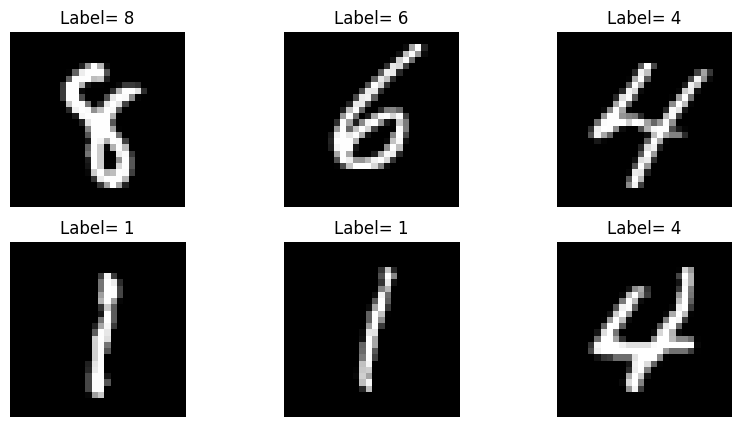

In [20]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we only have a single channel image
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title("Label= " + str(y_test[i].item()))
    plt.grid(False)
    plt.axis(False)
plt.show()

# 3. Vanilla GAN

In [21]:
# Generator

class Generator(nn.Module):
    def __init__(self, noise_size=128, hidden_size=256, output_size=28*28):
        '''
        noise_size: size of the noise vector taken as input by the generator
        '''
        super(Generator, self).__init__()

        # extracting parameters
        self.noise_size = noise_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # define generator sequential
        self.generator = nn.Sequential(
            # layer-1
            nn.Linear(self.noise_size, self.hidden_size),
            nn.LeakyReLU(0.2),
            
            # layer-2
            nn.Linear(self.hidden_size, self.hidden_size*2),
            nn.LeakyReLU(0.2),
            
            # layer-3
            nn.Linear(self.hidden_size*2, self.hidden_size*4),
            nn.LeakyReLU(0.2),

            # layer-4
            nn.Linear(self.hidden_size*4, self.output_size),
            nn.Tanh(),            
        )
    
    def forward(self, Z):
        out = self.generator(Z)
        return out


# Discriminator

class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=256, output_size=1):
        super(Discriminator, self).__init__()

        # extracting parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # define discriminator sequential
        self.discriminator = nn.Sequential(
            # layer-1
            nn.Linear(self.input_size, self.hidden_size*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # layer-2
            nn.Linear(self.hidden_size*4, self.hidden_size*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # layer-3
            nn.Linear(self.hidden_size*2, self.hidden_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # layer-4
            nn.Linear(self.hidden_size, self.output_size),
            nn.Sigmoid()
        )

    def forward(self, X):
        X = X.view(-1, 784)
        out = self.discriminator(X)
        return out

In [23]:
from sklearn.metrics import accuracy_score

# helper function to create noise
def create_noise(n_samples, noise_size=128):
    return Variable(torch.randn(n_samples, noise_size)).to(device)

# helper function to create ones array
def create_ones(n_samples):
    return Variable(torch.ones(n_samples, 1)).to(device)

# helper function to create zeros array
def create_zeros(n_samples):
    return Variable(torch.zeros(n_samples, 1)).to(device)

# helper function to evaluate the generator
def eval_generator(generator):
    n_samples = 4
    
    # create noise_vec
    noise_vec = create_noise(n_samples, generator.noise_size)

    # generate images from noise
    with torch.no_grad():
        generated_images = generator(noise_vec)

    plt.figure(figsize=(5,5))
    for i in range(n_samples):
        plt.subplot(2, 2, i+1)
        # copy the image back to cpu to reshape
        img = generated_images[i].cpu()
        # we only have a single channel image
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.title("Generated Image #" + str(i))
        plt.grid(False)
        plt.axis(False)
    plt.show()

# helper function to evaluate discriminator
def eval_discriminator(generator, discriminator, X_test):
    batch_size = len(X_test)

    # real labels
    real_label = create_ones(batch_size)
    # fake labels
    fake_label = create_zeros(batch_size)
    # stacking them together
    labels = torch.cat((real_label, fake_label), dim=0).to('cpu')

    
    # evaluate
    with torch.no_grad():
        # we do .round() to obtain binary 0/1 labels
        predicted_real_label = discriminator(X_test).round()
        # create noise vector
        noise_vec = create_noise(batch_size, generator.noise_size)
        # discriminator prediction on the noise vector
        predicted_fake_label = discriminator(generator(noise_vec)).round()
        # stacking them together
        predicted_labels = torch.cat((predicted_real_label, predicted_fake_label), dim=0).to('cpu')
        
        # compute the accuracy_score of the discriminator
        disc_accuracy = accuracy_score(labels, predicted_labels)
    
    return disc_accuracy

In [24]:
# print the model parameters
print(noise_size, hidden_size, input_size)

128 256 784


In [25]:
G = Generator(
    noise_size=noise_size,
    hidden_size=hidden_size,
    output_size=input_size # 28*28
).to(device)

D = Discriminator(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=1 # single sigmoid output
).to(device)

In [26]:
noise_vec = create_noise(len(X_test), noise_size)
noise_vec.shape

torch.Size([512, 128])

Accuracy of the Discriminator before training.

In [27]:
print("Accuracy of the discrimator on the test data before training:\n")
print(eval_discriminator(generator=G, discriminator=D, X_test=X_test))

Accuracy of the discrimator on the test data before training:

0.5302734375


Generated samples by the Generator before training.

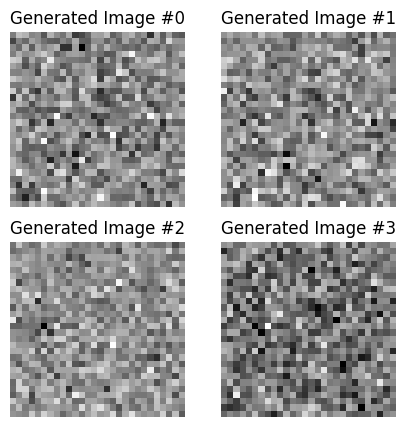

In [28]:
eval_generator(generator=G)

# 4. Objective

We use the modified minimax Loss for training the generator and discriminator.

Discriminator Loss:

Discriminator should identify the fake images generated by the Generator as fake (and should assign a label `0`) and identify the real images (from the dataset) as real (and should assign a label of `1`). So, here the objective function pertains to maximizing $\log{D(x)} + \log{(1 - D(G(z)))}$, where $x$ is a data-point from the real dataset, and $z$ is a noise vector.

Generator Loss:

Generator should try to fool the discriminator and make sure that the fake images (images generated by the generator), are being mistaken as real images (and being assigned a label of `1`) instead. So, the modified objective function pertains to maximizing $\log{D(G(z))}$, $z$ being the input noise.


# 5. Training

In [29]:
def train_generator(generator, discriminator, X_fake, optimizer, criterion):
    # zero grad
    optimizer.zero_grad()
    
    # extract batch size
    batch_size = len(X_fake)
    
    # create a vector of true labels (w.r.t. Generator)
    # since, the generator is trying to fool the discriminator, the true labels for these generated images should be `1` (w.r.t. generator)
    real_label = create_ones(batch_size)
    
    # predict the labels on the generated samples (generated by the generator) by the discriminator
    predicted_label = discriminator(X_fake)

    # calculate loss
    loss = criterion(predicted_label, real_label)
    # compute grads
    loss.backward()
    # update weights
    optimizer.step()

    return loss


def train_discriminator(generator, discriminator, X_real, X_fake, optimizer, criterion):
    # zero grad
    optimizer.zero_grad()
    
    # extract batch size
    batch_size = len(X_real)
    
    # the discriminator is trying to distinguish between fake (generated images) and real images (images from the dataset)

    # training on the real images from the dataset
    # so the assigned labels for the real images (images from the dataset) should be `1`
    prediction_real = discriminator(X_real)
    # compute real loss
    loss_real = criterion(prediction_real, create_ones(batch_size))
    # compute grad
    loss_real.backward()


    # training on the fake images generated by the generator
    # so the assigned labels for the fake images (images generated by the generator) should be `0`
    prediction_fake = discriminator(X_fake)
    # compute fake loss
    loss_fake = criterion(prediction_fake, create_zeros(batch_size))
    # compute grad
    loss_fake.backward()

    # update the grads
    optimizer.step()

    return loss_real + loss_fake

In [30]:
from sklearn.metrics import accuracy_score

def train_gan(generator, discriminator, optimizers, criterions, num_epochs=300, k=1):
    # keep track of generator and discriminator losses during training
    g_losses = []
    d_losses = []

    # train generator and discriminator
    for epoch in tqdm(range(num_epochs)):
        # keep track of epoch training loss of generator and discriminator
        g_epoch_loss = 0.0
        d_epoch_loss = 0.0  
        
        for phase in ['train', 'test']:
            if phase == 'train':
                # set generator, discriminator to training mode
                generator.train()
                discriminator.train()
                
                # extarct training data (both fake and real)
                for batch in image_dataloaders[phase]:
                    # extract features
                    X_real,_ = batch
                    # reshape data and add it to the GPU
                    X_real = X_real.reshape(-1, 28*28).to(device)
                    # extract batch_size
                    batch_size = len(X_real)
                    
                    # create a noise vector to generate inputs
                    noise_vec = create_noise(batch_size, generator.noise_size)
                    
                    # train the discriminator 'k' times
                    for step in range(k):
                        # generate fake images using generator (make sure to not add these to the computational graph), we don't want this included in the gradient calculation
                        X_fake = generator(noise_vec).detach()
                        d_epoch_loss += train_discriminator(generator, discriminator, X_real, X_fake, optimizers['discriminator'], criterions['discriminator'])

                    # train the generator once
                    X_fake = generator(noise_vec)
                    g_epoch_loss += train_generator(generator, discriminator, X_fake, optimizers['generator'], criterions['generator'])

            elif phase=='test':
                # set the generator and discriminator to evaluation mode
                generator.eval()
                discriminator.eval()
                
                # print info every 50 epochs
                if epoch%50 == 0:
                    # extract discriminator accuracy on the X_test data and generator examples
                    disc_accuracy = eval_discriminator(generator, discriminator, X_test)

                    # print epoch info
                    print('-----------------------------------------')
                    print('Epoch: {}/{}'.format(epoch+1, num_epochs))
                    print('Discriminator Accuracy: {:2f}'.format(disc_accuracy))
                    print('Samples Generated by Generator:')


                    # check samples generated by the generator
                    eval_generator(generator)
        
        # update the losses
        n_batches = len(image_dataloaders['train'])
        with torch.no_grad():
            g_losses.append(g_epoch_loss/n_batches)
            d_losses.append(d_epoch_loss/(k*n_batches))

        if epoch%10 == 0:
            print('Epoch {}: Generator Loss: {:.6f} Discriminator Loss: {:.6f}\r'.format(epoch+1, g_losses[-1], d_losses[-1]))
    
    # convert everything to numpy
    g_losses = torch.stack(g_losses).to('cpu').numpy()
    d_losses = torch.stack(d_losses).to('cpu').numpy()

    
    # return generator, discriminator, gen_losses and disc_losses
    return generator, discriminator, g_losses, d_losses

In [31]:
# define parameters for training

'''
# model hyper-parameters

# input_size of discriminator and output size of generator
input_size = 28*28
# size of the noise vector, input_size for generator
noise_size = 128
# size of hidden layer in 
hidden_size = 256


# other hyper-parameters
batch_size = 512
num_epochs = 250


# no. of epochs of training discriminator per epoch of generator training
k = 1
'''

lr = 2e-4

optimizers = {
    'generator': torch.optim.Adam(params=G.parameters(), lr=lr),
    'discriminator': torch.optim.Adam(params=D.parameters(), lr=lr)
}

criterions = {
    'generator': nn.BCELoss(),
    'discriminator': nn.BCELoss()
}

  0%|          | 0/250 [00:00<?, ?it/s]

-----------------------------------------
Epoch: 1/250
Discriminator Accuracy: 0.997070
Samples Generated by Generator:


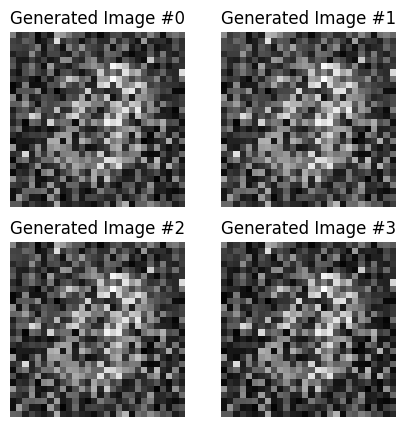

  0%|          | 1/250 [00:06<26:03,  6.28s/it]

Epoch 1: Generator Loss: 1.525865 Discriminator Loss: 0.851716


  4%|▍         | 11/250 [01:05<23:33,  5.91s/it]

Epoch 11: Generator Loss: 2.011730 Discriminator Loss: 0.872894


  8%|▊         | 21/250 [02:04<22:27,  5.88s/it]

Epoch 21: Generator Loss: 2.803024 Discriminator Loss: 0.451698


 12%|█▏        | 31/250 [03:03<21:33,  5.91s/it]

Epoch 31: Generator Loss: 2.571861 Discriminator Loss: 0.558484


 16%|█▋        | 41/250 [04:01<20:29,  5.88s/it]

Epoch 41: Generator Loss: 3.141154 Discriminator Loss: 0.446422


 20%|██        | 50/250 [04:55<19:38,  5.89s/it]

-----------------------------------------
Epoch: 51/250
Discriminator Accuracy: 0.948242
Samples Generated by Generator:


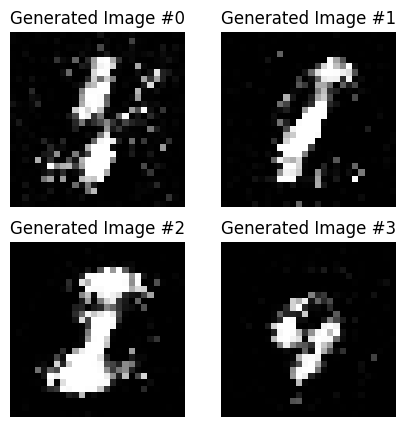

 20%|██        | 51/250 [05:01<19:38,  5.92s/it]

Epoch 51: Generator Loss: 3.016550 Discriminator Loss: 0.498960


 24%|██▍       | 61/250 [06:00<18:39,  5.92s/it]

Epoch 61: Generator Loss: 2.765111 Discriminator Loss: 0.535731


 28%|██▊       | 71/250 [06:58<17:33,  5.88s/it]

Epoch 71: Generator Loss: 2.367594 Discriminator Loss: 0.652501


 32%|███▏      | 81/250 [07:57<16:33,  5.88s/it]

Epoch 81: Generator Loss: 2.273186 Discriminator Loss: 0.649104


 36%|███▋      | 91/250 [08:56<15:35,  5.88s/it]

Epoch 91: Generator Loss: 2.160531 Discriminator Loss: 0.710773


 40%|████      | 100/250 [09:49<14:41,  5.87s/it]

-----------------------------------------
Epoch: 101/250
Discriminator Accuracy: 0.789062
Samples Generated by Generator:


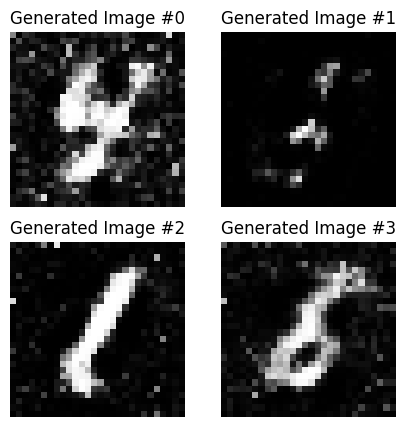

 40%|████      | 101/250 [09:55<14:40,  5.91s/it]

Epoch 101: Generator Loss: 1.923589 Discriminator Loss: 0.790711


 44%|████▍     | 111/250 [10:54<13:38,  5.89s/it]

Epoch 111: Generator Loss: 1.838834 Discriminator Loss: 0.827652


 48%|████▊     | 121/250 [11:53<12:37,  5.87s/it]

Epoch 121: Generator Loss: 1.735736 Discriminator Loss: 0.889535


 52%|█████▏    | 131/250 [12:52<11:39,  5.88s/it]

Epoch 131: Generator Loss: 1.632225 Discriminator Loss: 0.887464


 56%|█████▋    | 141/250 [13:50<10:38,  5.86s/it]

Epoch 141: Generator Loss: 1.582727 Discriminator Loss: 0.947158


 60%|██████    | 150/250 [14:43<09:47,  5.88s/it]

-----------------------------------------
Epoch: 151/250
Discriminator Accuracy: 0.812500
Samples Generated by Generator:


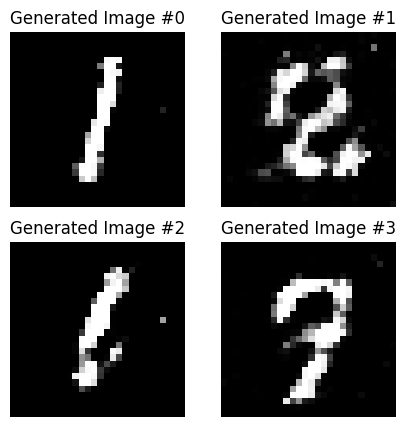

 60%|██████    | 151/250 [14:49<09:44,  5.90s/it]

Epoch 151: Generator Loss: 1.549353 Discriminator Loss: 0.956887


 64%|██████▍   | 161/250 [15:49<09:01,  6.08s/it]

Epoch 161: Generator Loss: 1.405169 Discriminator Loss: 1.014200


 68%|██████▊   | 171/250 [16:48<07:46,  5.90s/it]

Epoch 171: Generator Loss: 1.371270 Discriminator Loss: 1.051852


 72%|███████▏  | 181/250 [17:48<06:46,  5.89s/it]

Epoch 181: Generator Loss: 1.376050 Discriminator Loss: 1.046578


 76%|███████▋  | 191/250 [18:47<05:49,  5.92s/it]

Epoch 191: Generator Loss: 1.295757 Discriminator Loss: 1.059472


 80%|████████  | 200/250 [19:40<04:56,  5.92s/it]

-----------------------------------------
Epoch: 201/250
Discriminator Accuracy: 0.784180
Samples Generated by Generator:


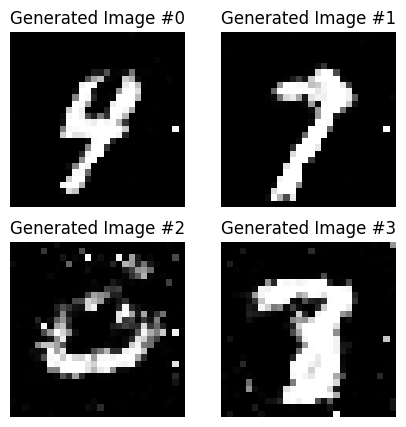

 80%|████████  | 201/250 [19:46<04:51,  5.95s/it]

Epoch 201: Generator Loss: 1.262189 Discriminator Loss: 1.090566


 84%|████████▍ | 211/250 [20:45<03:49,  5.88s/it]

Epoch 211: Generator Loss: 1.230547 Discriminator Loss: 1.091888


 88%|████████▊ | 221/250 [21:44<02:51,  5.90s/it]

Epoch 221: Generator Loss: 1.278347 Discriminator Loss: 1.081352


 92%|█████████▏| 231/250 [22:43<01:53,  6.00s/it]

Epoch 231: Generator Loss: 1.187311 Discriminator Loss: 1.126563


 96%|█████████▋| 241/250 [23:42<00:52,  5.89s/it]

Epoch 241: Generator Loss: 1.178640 Discriminator Loss: 1.122672


100%|██████████| 250/250 [24:35<00:00,  5.90s/it]


In [32]:
generator, discriminator, gen_losses, disc_losses = train_gan(
    generator=G,
    discriminator=D,
    optimizers=optimizers,
    criterions=criterions,
    num_epochs=num_epochs,
    k=k
)

In [48]:
with torch.no_grad():
    g_losses = torch.stack(gen_losses).to('cpu').numpy()
    d_losses = torch.stack(disc_losses).to('cpu').numpy()

<function matplotlib.pyplot.show(close=None, block=None)>

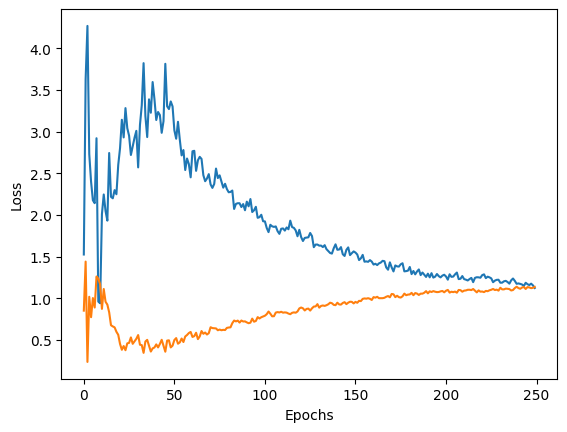

In [49]:
# printing the learning curve
plt.figure()
plt.plot(g_losses, label="Generator Losses")
plt.plot(d_losses, label="Discriminator Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show

In [33]:
# save the models
generator_savepath = os.path.join('models', 'G_250.pth')
discriminator_savepath = os.path.join('models', 'D_250.pth')

In [34]:
'''
# save generator
torch.save(G.state_dict(), generator_savepath)
# save discriminator
torch.save(D.state_dict(), discriminator_savepath)
'''

In [51]:
# load the models

G = Generator(
    noise_size=noise_size,
    hidden_size=hidden_size,
    output_size=input_size # 28*28
).to(device)

G.load_state_dict(torch.load(generator_savepath))

D = Discriminator(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=1 # single sigmoid output
).to(device)

D.load_state_dict(torch.load(discriminator_savepath))

<All keys matched successfully>

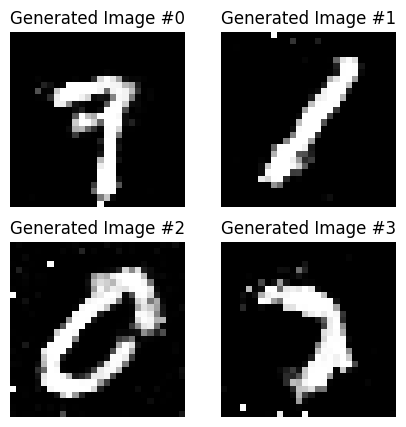

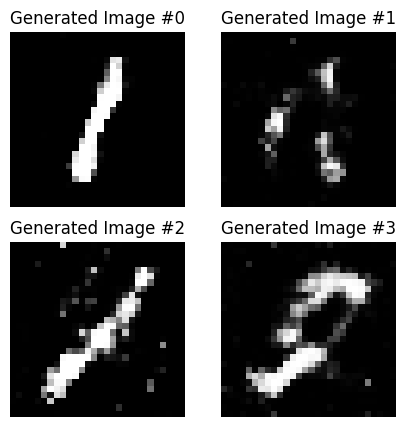

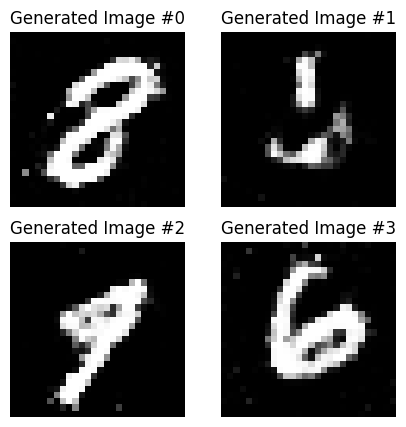

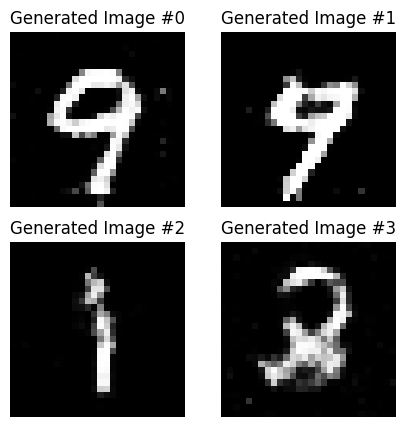

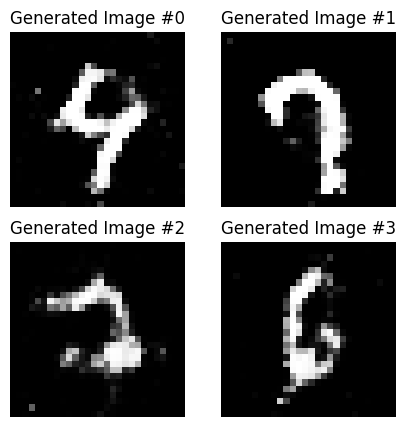

In [52]:
n_plots = 5
for _ in range(n_plots):
    eval_generator(G)